In [1]:
library(tidyverse)
library(modelr)
options(na.action = na.warn)

# setting a random seed ensures that randomly generated numbers are the same everytime you run the notebook
# ensures reproducible results
set.seed(2021)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Let's look at how we can create a Train/Validation/Test split of our tibble to develop a linear model for a dataset

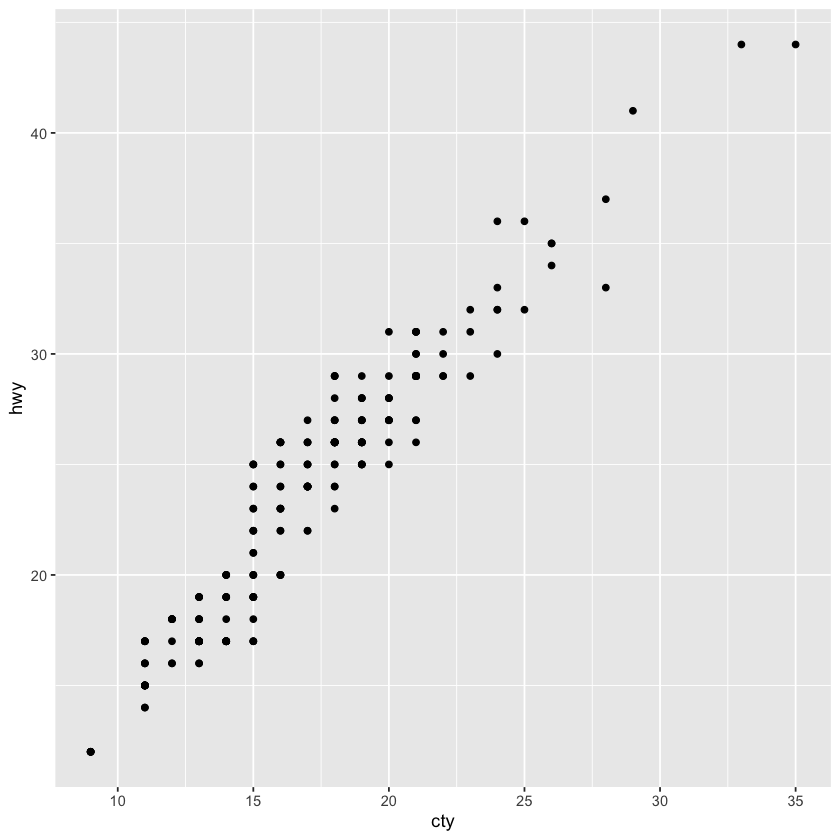

In [2]:
ggplot(mpg) + 
    geom_point(aes(cty, hwy))

- Too late! Data Leakage has already occurred.
- We can no longer effectively evaluate an answer to the question: Is a linear model a good predictive model?
- Let's still use the ```mpg``` dataset to see how different train/validation/test splits may affect our thinking.
 * 60%/20%/20% split

In [3]:
# add a row id to each row of mpg
mpg_id <- mpg %>%
    mutate(id = row_number()) %>%
    select(id, everything()) %>%
    print()

# A tibble: 234 x 12
      id manufacturer model    displ  year   cyl trans   drv     cty   hwy fl   
   <int> <chr>        <chr>    <dbl> <int> <int> <chr>   <chr> <int> <int> <chr>
 1     1 audi         a4         1.8  1999     4 auto(l… f        18    29 p    
 2     2 audi         a4         1.8  1999     4 manual… f        21    29 p    
 3     3 audi         a4         2    2008     4 manual… f        20    31 p    
 4     4 audi         a4         2    2008     4 auto(a… f        21    30 p    
 5     5 audi         a4         2.8  1999     6 auto(l… f        16    26 p    
 6     6 audi         a4         2.8  1999     6 manual… f        18    26 p    
 7     7 audi         a4         3.1  2008     6 auto(a… f        18    27 p    
 8     8 audi         a4 quat…   1.8  1999     4 manual… 4        18    26 p    
 9     9 audi         a4 quat…   1.8  1999     4 auto(l… 4        16    25 p    
10    10 audi         a4 quat…   2    2008     4 manual… 4        20    28 p    
# … wit

In [4]:
# take a random sample of 60% of the data
train <- mpg_id %>%
    sample_frac(.60) %>%
    print()

# A tibble: 140 x 12
      id manufacturer model     displ  year   cyl trans  drv     cty   hwy fl   
   <int> <chr>        <chr>     <dbl> <int> <int> <chr>  <chr> <int> <int> <chr>
 1   135 lincoln      navigato…   5.4  1999     8 auto(… r        11    17 r    
 2   166 subaru       impreza …   2.2  1999     4 auto(… 4        21    26 r    
 3   174 toyota       4runner …   2.7  1999     4 manua… 4        15    20 r    
 4   186 toyota       camry       3.5  2008     6 auto(… f        19    28 r    
 5   140 mercury      mountain…   4.6  2008     8 auto(… 4        13    19 r    
 6    70 dodge        ram 1500…   4.7  2008     8 manua… 4         9    12 e    
 7   192 toyota       camry so…   3    1999     6 manua… f        18    26 r    
 8   233 volkswagen   passat      2.8  1999     6 manua… f        18    26 p    
 9   102 honda        civic       1.6  1999     4 manua… f        25    32 r    
10   110 hyundai      sonata      2.4  1999     4 manua… f        18    27 r    
# … wit

In [6]:
# recall what an anti-join does!
valid_test <- anti_join(mpg_id, train, by = "id") %>% print()

# A tibble: 94 x 12
      id manufacturer model     displ  year   cyl trans  drv     cty   hwy fl   
   <int> <chr>        <chr>     <dbl> <int> <int> <chr>  <chr> <int> <int> <chr>
 1     2 audi         a4          1.8  1999     4 manua… f        21    29 p    
 2     3 audi         a4          2    2008     4 manua… f        20    31 p    
 3     5 audi         a4          2.8  1999     6 auto(… f        16    26 p    
 4     6 audi         a4          2.8  1999     6 manua… f        18    26 p    
 5     8 audi         a4 quatt…   1.8  1999     4 manua… 4        18    26 p    
 6     9 audi         a4 quatt…   1.8  1999     4 auto(… 4        16    25 p    
 7    10 audi         a4 quatt…   2    2008     4 manua… 4        20    28 p    
 8    12 audi         a4 quatt…   2.8  1999     6 auto(… 4        15    25 p    
 9    14 audi         a4 quatt…   3.1  2008     6 auto(… 4        17    25 p    
10    21 chevrolet    c1500 su…   5.3  2008     8 auto(… r        14    20 r    
# … with

In [7]:
# split the non-training data in half for a 60/20/20 split
valid <- valid_test %>%
    sample_frac(.50)
test <- anti_join(valid_test, valid, by = "id")

In [8]:
# drop id columns from each
train <- select(train, -id)
valid <- select(valid, -id)
test <- select(test, -id)

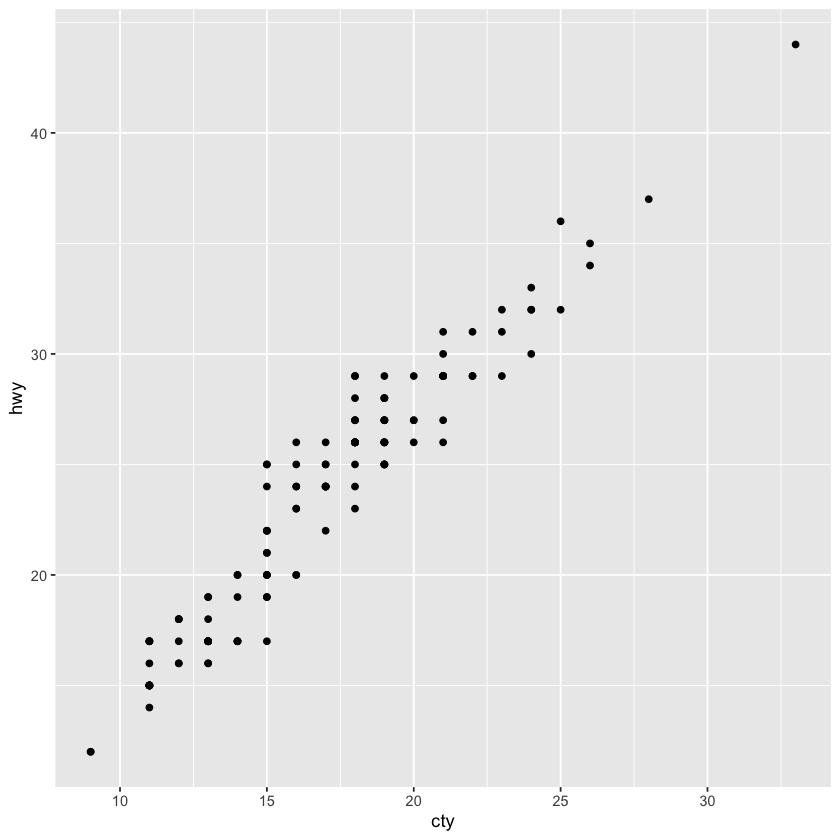

In [9]:
ggplot(train) +
    geom_point(aes(cty, hwy))

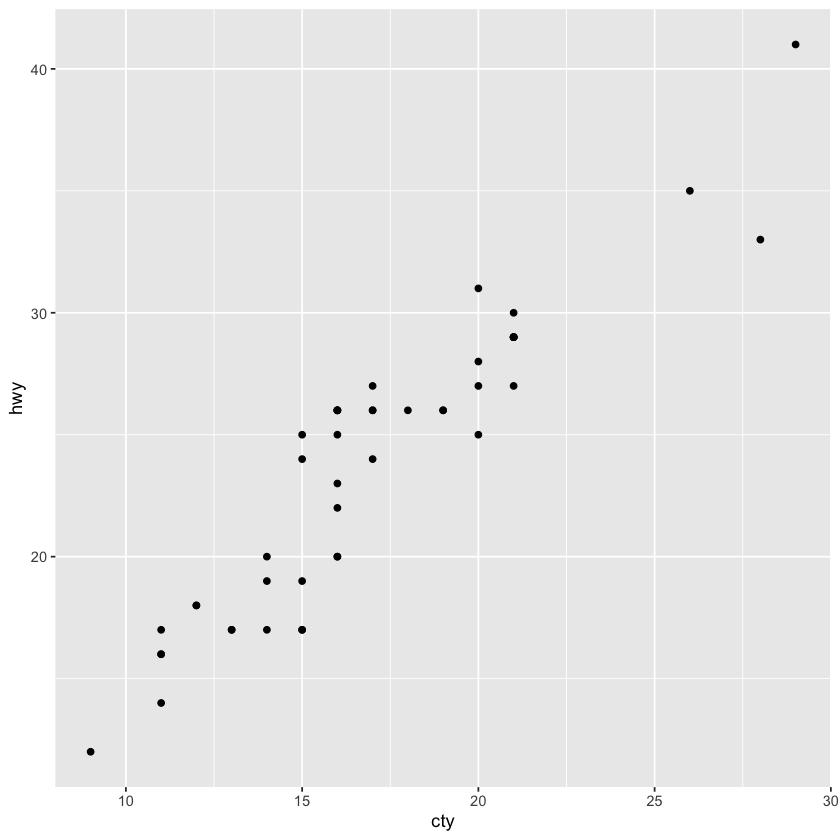

In [10]:
ggplot(valid) + 
    geom_point(aes(cty, hwy))

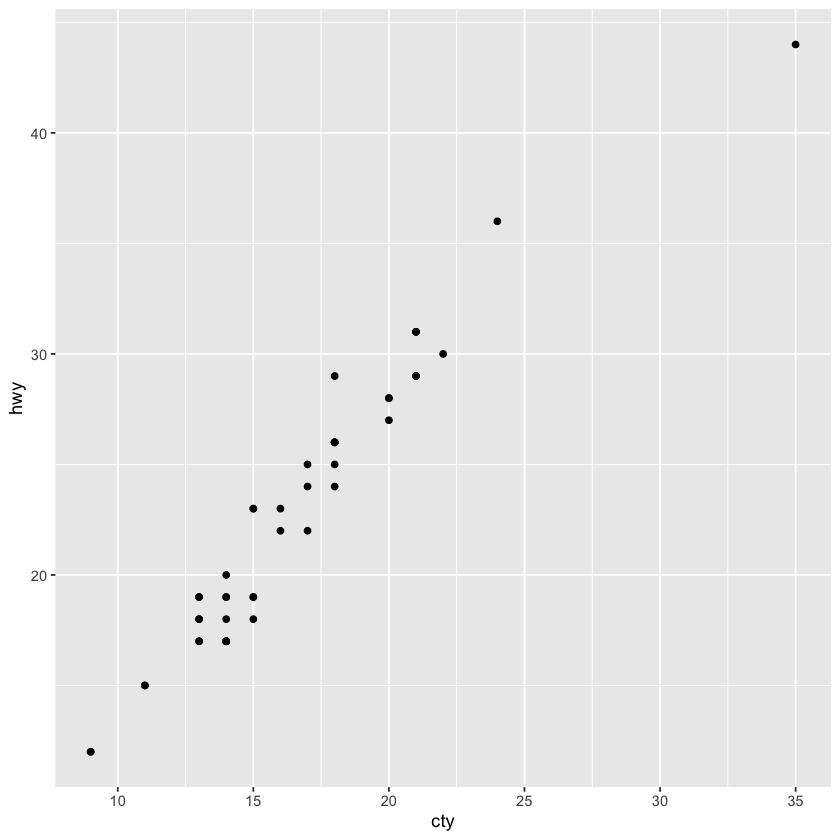

In [11]:
ggplot(test) + 
    geom_point(aes(cty, hwy))

Do you notice any differences between the three datasets?

In [12]:
# we create an RMSE (Root Mean Squared Error) which finds the error for a linear model that predicts hwy from cty
RMSE <- function(a, data) {
    preds <- a[1] + data$x * a[2]
    diffs <- data$y - preds
    sqrt(mean(diffs^2))
}

(best <- optim(c(0, 0), RMSE, data = mutate(train, x = cty, y = hwy)))

$par
[1] 1.016102 1.329867

$value
[1] 1.578988

$counts
function gradient 
      79       NA 

$convergence
[1] 0

$message
NULL

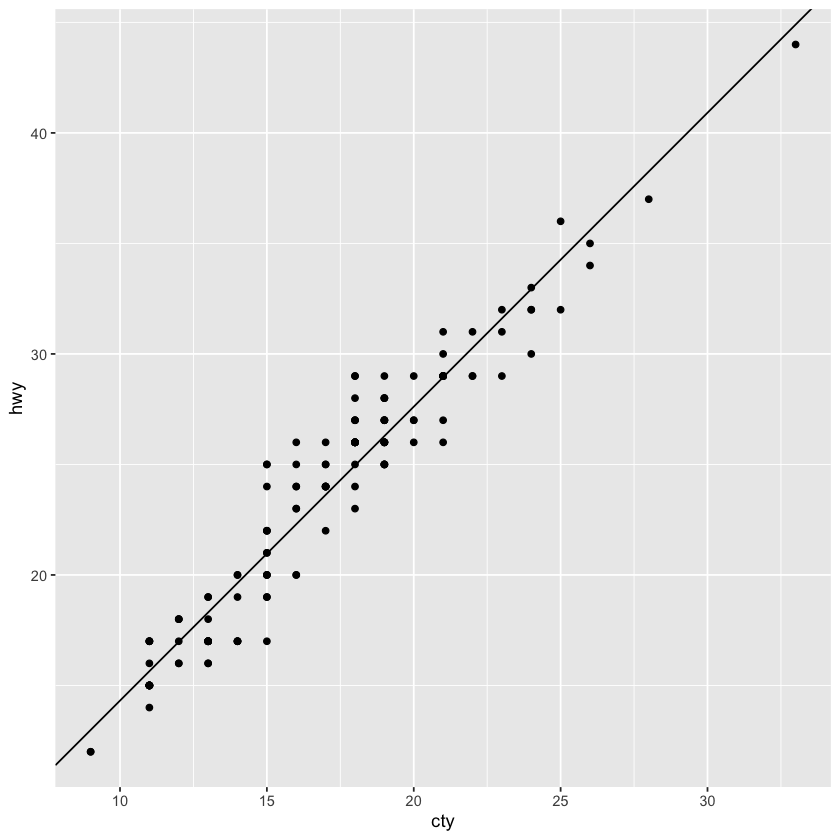

In [13]:
a <- best$par
ggplot() +
    geom_point(data = train, aes(cty,hwy)) +    # the data
    geom_abline(aes(intercept = a[1], slope = a[2]))

How well does this generalize to the validation set?

[1] 2.215408

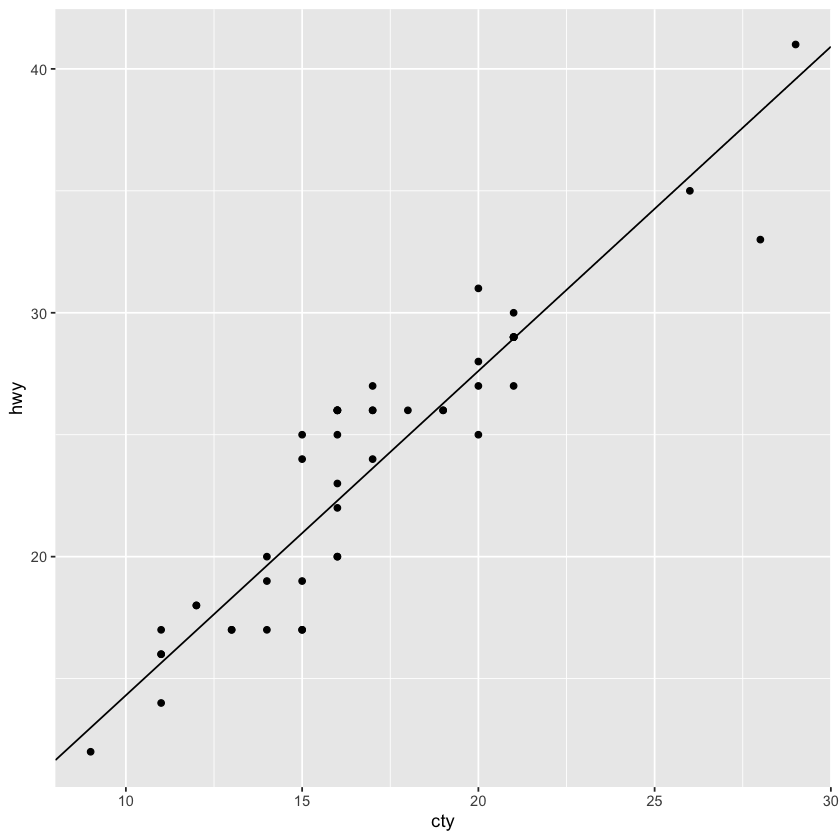

In [14]:
RMSE(a, mutate(valid, x=cty, y=hwy))

ggplot() +
    geom_point(data = valid, aes(cty,hwy)) +    # the data
    geom_abline(aes(intercept = a[1], slope = a[2]))

- Why is the error larger on the validation set than the training set?
- Let's try a different model before finishing with our test set.

In [15]:
# we'll use a different error function to find a good linear model
avg_abs_diff <- function(a, data) {
    preds <- a[1] + data$x * a[2]
    diffs <- data$y - preds
    mean(abs(diffs))
}

(best2 <- optim(c(0, 0), avg_abs_diff, data = mutate(train, x = cty, y = hwy)))

$par
[1] 0.9996182 1.3333515

$value
[1] 1.266667

$counts
function gradient 
     137       NA 

$convergence
[1] 0

$message
NULL

[1] 2.2127

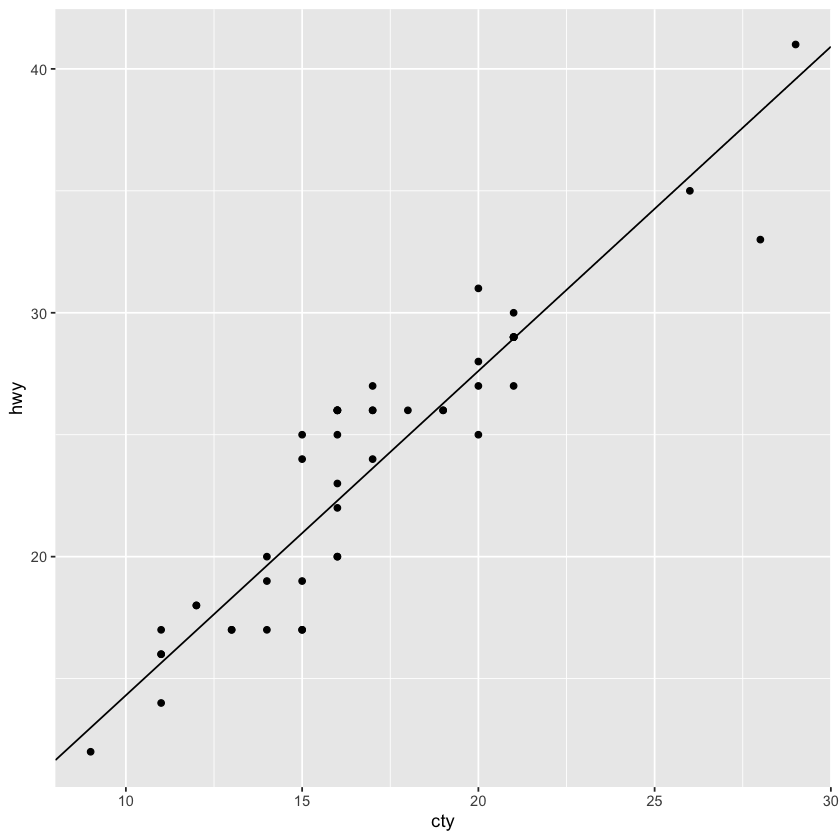

In [16]:
RMSE(best2$par, mutate(valid, x=cty, y=hwy))

ggplot() +
    geom_point(data = valid, aes(cty,hwy)) +    # the data
    geom_abline(aes(intercept = a[1], slope = a[2]))

- Although we computed the second model using a different **loss function**, we still have to use the same **metric** to compare models.
- A **loss function** is the error term you want to minimize using an optimization procedure.
- A **metric** is the score you use for evaluating a model.
- Sometimes you can use your metric as a loss function, but not always!
- A loss function has to satisfy certain mathematical properties so you can use various optimization algorithms.

At this point we might say we are done with model development. Our best model is given by the line:
```y = 1.333 x + .999```
- The final step: Evaluate the model on the test set.

In [17]:
RMSE(best2$par, mutate(test, x=cty, y=hwy))

[1] 1.684277

In data science competitions, often there is a publicly available dataset and a private test dataset. Data scientists/enthusiasts will take the publicly available data, split into train and validation and go into model development. Each will submit their model for evaluation on the test set. The test set determines the "best" model or the "winner."

Attempt:
- Does it make sense to create a separate linear model for each specific class of car?
- What steps would you take to answer this question?
- Pick a class of car, split it into training and validation and fit a linear model to this class of car.

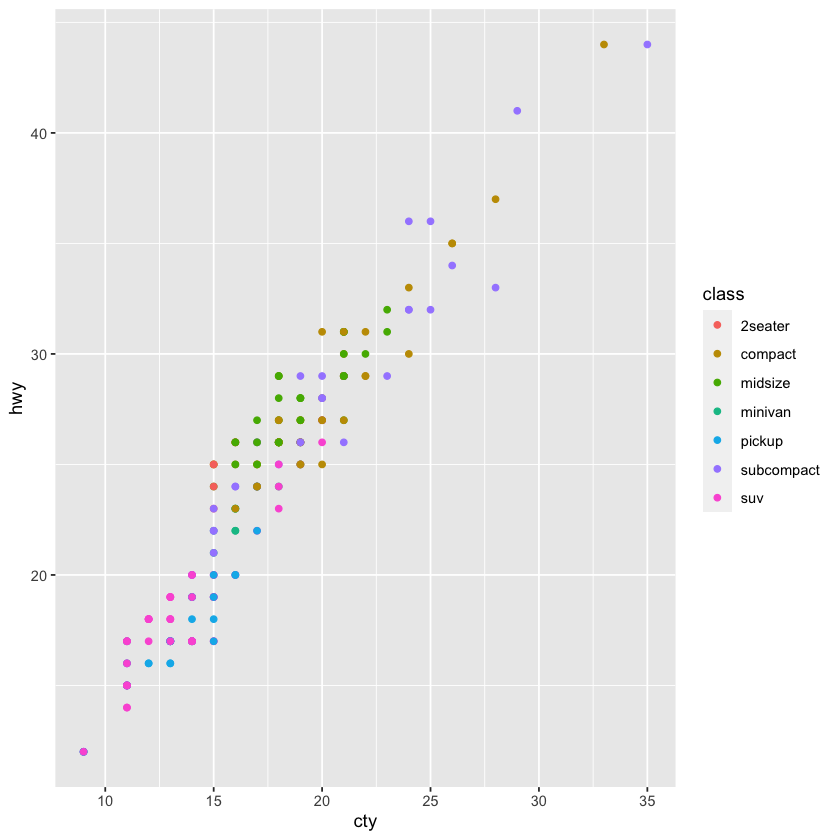

In [18]:
ggplot(mpg) +
    geom_point(aes(cty, hwy, color=class))

In [19]:
mpg_suv <- filter(mpg, class == "suv")